### Statistical performance analysis with Two's Complement encoding

In [1]:
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt
from collections import Counter

In [7]:
e_x = 10*(np.random.rand(2)*2 -1)  
e_y = 10*(np.random.rand(2)*2 -1)   

In [8]:
eta_sets = [np.random.uniform(-1, 1, 7) for _ in range(1000)]

The shortest vector is: [5.20637463 3.52196031]
The length of the shortest vector is: 6.285741102326193
The coefficients are: a = 0, b = -1
Percentage of eta sets matching the shortest vector: 1.3%


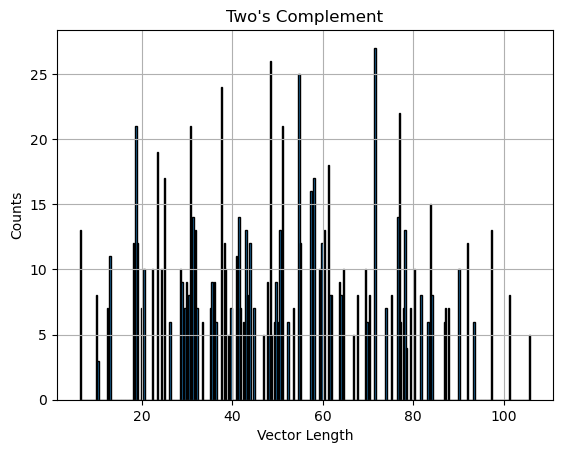

In [9]:
def pauli_z():
    return np.array([[1, 0], [0, -1]])

def identity():
    return np.eye(2)

def tensor_product(operators):
    result = operators[0]
    for op in operators[1:]:
        result = np.kron(result, op)
    return result

def construct_hamiltonian(num_qubits, coefficients, mu):
    H = np.zeros((2**num_qubits, 2**num_qubits))
    for i, coeff in enumerate(coefficients):
        ops = [identity()] * num_qubits
        ops[i] = pauli_z()
        ops[i + 1] = pauli_z()
        H += coeff * tensor_product(ops)
    
    for i in range(num_qubits - 1):  
        ops = [identity()] * num_qubits
        ops[i] = pauli_z()
        H += mu * tensor_product(ops)
    
    return H

def compute_eigenvalues_and_eigenvectors(H):
    eigenvalues, eigenvectors = np.linalg.eig(H)
    return eigenvalues, eigenvectors

def order_eigenvectors_by_energy(eigenvalues, eigenvectors):
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

def decode_eigenvector_amplitude_based(eigenvector, num_bits_per_coordinate):
    total_probability = 0
    weighted_x_sum = 0
    weighted_y_sum = 0
    
    for index, amplitude in enumerate(eigenvector):
        probability = np.abs(amplitude)**2
        total_probability += probability
        
        binary_str = format(index, f'0{2 * num_bits_per_coordinate}b')
        x_bin = binary_str[:num_bits_per_coordinate]
        y_bin = binary_str[num_bits_per_coordinate:]
        
        def twos_complement(bin_str):
            n = len(bin_str)
            value = int(bin_str, 2)
            if bin_str[0] == '1':  
                value -= (1 << n)
            return value
        
        x = twos_complement(x_bin)
        y = twos_complement(y_bin)
        
        weighted_x_sum += probability * x
        weighted_y_sum += probability * y
    
    average_x = weighted_x_sum / total_probability
    average_y = weighted_y_sum / total_probability
    
    return (average_x, average_y)

def calculate_vector_length(decoded_coordinates, e_x, e_y):
    a, b = decoded_coordinates
    v = a * e_x + b * e_y
    return np.linalg.norm(v)

def find_shortest_vector(e_x, e_y, range_limit):
    shortest_length = float('inf')
    shortest_vector = None
    best_a = best_b = None

    for a in range(-range_limit, range_limit + 1):
        for b in range(-range_limit, range_limit + 1):
            if a == 0 and b == 0:
                continue  # skip the zero vector
            v = a * e_x + b * e_y
            length = np.linalg.norm(v)
            if length < shortest_length:
                shortest_length = length
                shortest_vector = v
                best_a = a
                best_b = b

    return shortest_vector, shortest_length, best_a, best_b

num_qubits = 8  
num_bits_per_coordinate = 4  
mu = 0.000001 

vector_lengths = []

# compute the shortest vector using the basis vectors
shortest_vector, shortest_length, best_a, best_b = find_shortest_vector(e_x, e_y, range_limit=10)

# analyse each set of eta coefficients
count_matching_vectors = 0
for coefficients in eta_sets:
    H = construct_hamiltonian(num_qubits, coefficients, mu)
    eigenvalues, eigenvectors = compute_eigenvalues_and_eigenvectors(H)
    sorted_eigenvalues, sorted_eigenvectors = order_eigenvectors_by_energy(eigenvalues, eigenvectors)
    
    first_excited_eigenvector = sorted_eigenvectors[:, 1]
    decoded_coordinates = decode_eigenvector_amplitude_based(first_excited_eigenvector, num_bits_per_coordinate)
    if decoded_coordinates == (0, 0):
        continue  # ignore zero vector
    vector_length = calculate_vector_length(decoded_coordinates, e_x, e_y)
    
    vector_lengths.append(vector_length)
    
    # check if the vector length matches the shortest length
    if np.isclose(vector_length, shortest_length, atol=1e-5):
        count_matching_vectors += 1

percentage_matching = (count_matching_vectors / len(eta_sets)) * 100

print(f"The shortest vector is: {shortest_vector}")
print(f"The length of the shortest vector is: {shortest_length}")
print(f"The coefficients are: a = {best_a}, b = {best_b}")
print(f"Percentage of eta sets matching the shortest vector: {percentage_matching}%")

bin_width = 0.3 
bins = np.arange(min(vector_lengths), max(vector_lengths) + bin_width, bin_width)

plt.hist(vector_lengths, bins=bins, edgecolor='black')
plt.xlabel('Vector Length')
plt.ylabel('Counts')
plt.title("Two's Complement")
plt.grid(True)
plt.show()